# LDA Topic Modelling from Hansard
## Using LDA to try to extract topics from unlabelled UK parliamentary debates.

### Data preparation
A single-day example of the data can be found in `/data/2016-01-14.json` to make following this more clear.

In [1]:
import lzma
import pickle
from pprint import pprint

raw_data = None
with lzma.open(f"../data/2016-today.xz", "rb") as f:
    raw_data = pickle.load(f)

# Check loaded successfully by printing date of first 2 days in data.
pprint(raw_data[0]["date"])
pprint(raw_data[1]["date"])

'2016-01-05'
'2016-01-06'


Here we recursively loop through the "debates" as they have a nested structure. The problem we face here is that some things Hansard lists as "debates" are/have collections of debates or even just statements. So we try to filter down to the debates on the deepest level and those which have more than 1 contribution so therefore are not statements.

In [2]:
import numpy as np
import pandas as pd


def recurse_debates(debates):
    for deb in debates:  # Loop through debates
        contributions = [
            x for x in deb["items"] if x["type"] == "contribution"
        ]  # Get only the items which have contributions
        if (
            len(contributions) > 1
        ):  # Keep only debates that have more than one contribution.
            yield np.array(
                [deb["title"], " ".join([item["text"] for item in deb["items"]])]
            )  # Yield debate item in format [title, joined text]
        if (
            "child_debates" in deb
        ):  # If debate has child debates loop through those and yield items.
            for item in recurse_debates(deb["child_debates"]):
                yield item


def generate_debates(raw_data):
    for day in raw_data:  # Loop through days in data
        for item in recurse_debates(day["debates"]):
            yield item  # Yield each debate item


df = pd.DataFrame(list(generate_debates(raw_data)), columns=["title", "text"])
df

,title,text
0,Out-of-hospital Care,1. What progress his Department has made on i...
1,GP Services,2. What progress his Department is making on ...
2,Hospital Trusts: Deficits,3. What proportion of hospital trusts are in ...
3,Rare Diseases,4. How many people have diseases classified b...
4,Social Care Budgets: A&E Attendance,5. What assessment he has made of the effect ...
...,...,...
13988,Education Recovery,"With permission, Mr Deputy Speaker, I will mak..."
13989,Official Development Assistance,Application for emergency debate (Standing Ord...
13990,Points of Order,"On a point of order, Mr Deputy Speaker. This i..."
13991,Advanced Research and Invention Agency Bill,[Relevant documents: Third Report of the Scien...


### Preprocessing
Preprocessing is at first done with [Gensim's preprocessing](https://radimrehurek.com/gensim/parsing/preprocessing.html) which does all of the usual removal of unwanted chars and stopwords, as well as tokenisation and stemming.

In [3]:
from gensim.parsing.preprocessing import preprocess_documents

# Grab just the text from the original data.
processed_corp = preprocess_documents(df["text"])
print(processed_corp[0])

['progress', 'depart', 'integr', 'improv', 'care', 'provid', 'outsid', 'hospit', 'happi', 'new', 'year', 'speaker—and', 'happi', 'new', 'year', 'familiar', 'face', 'opposit', 'shadow', 'cabinet', 'govern', 'commit', 'transform', 'hospit', 'care', 'commun', 'seen', 'excel', 'progress', 'area', 'led', 'integr', 'pioneer', 'torbai', 'greenwich', 'govern', 'remain', 'fulli', 'commit', 'deliv', 'integr', 'programm', 'better', 'care', 'fund', 'vanguard', 'seventi', 'cent', 'peopl', 'prefer', 'die', 'home', 'allow', 'peopl', 'die', 'hospit', 'chang', 'netherland', 'ow', 'better', 'social', 'care', 'provid', 'outsid', 'hospit', 'messag', 'minist', 'clinic', 'commiss', 'group', 'try', 'hard', 'bring', 'integr', 'servic', 'grate', 'hon', 'friend', 'rais', 'issu', 'share', 'view', 'want', 'greater', 'choic', 'end', 'life', 'care', 'peopl', 'abl', 'care', 'die', 'place', 'choos', 'appropri', 'need', 'hospic', 'hospit', 'home', 'recent', 'choic', 'review', 'set', 'vision', 'enabl', 'greater', 'choi

Next we write out the document frequencies of each word to determine a suitable filter threshold. LDA is sensitive to very high or low occurring words so we have to filter them out to get a more respresentative picture for each document. I have chosen between 0.1% and 60%.

In [4]:
from collections import defaultdict

doc_count = 0
frequencies = defaultdict(int)  # The doc frequencies of each token.
for doc in processed_corp:
    doc_count += 1
    doc_contains = set()
    for word in doc:
        doc_contains.add(word)
    for word in doc_contains:
        frequencies[word] += 1

# A sorted array of the format [(token, doc_count, frequency)]. For tokens in more than 2 docs (to reduce size for sorting).
freq_sorted = sorted(
    [
        (key, val, round(val * 100.0 / doc_count, 3))
        for (key, val) in frequencies.items()
        if val > 2
    ],
    key=lambda x: x[1],
)

with open("../logs/sorted_frequencies.txt", "w") as log_file:
    pprint(freq_sorted, log_file)

In [5]:
final_words = [word for (word, count, perc) in freq_sorted if 0.1 < perc < 60]
print(final_words[:50])

['paperless', 'unattain', 'sharm', 'dieter', 'irk', 'bellicos', 'jubeir', 'nusra', 'want—and', 'not—to', 'tangent', 'authorities—and', 'vermin', 'principle”', 'snag', 'jerri', 'shall—', 'decision—that', 'activity”', '“foreign', '“poor', 'sc’', 'faceti', 'shona', 'investment—and', 'people—mani', '”other', 'bach', 'clayton', 'warzon', 'microwav', 'balmor', 'pedestrianis', 'vauxhall’', 'can—', 'chickenhal', 'january—second', 'tatti', 'buzzard', 'fowler', 'january—remain', 'is“no', 'today—on', 'society—and', 'that—h', 'see”', 'law—it', 'striven', 'abuse”', 'vibrat']


There is still clearly some cleaning to be done with this final list of words but we can move on for now. Next we filter all words not in the `final_words` out of the corpus. Then we can, using Gensim, create a dictionary for each word in the corpus (i.e. assign each word a unique number), and covert each document to its "bag of words" representation (i.e remove the ordering from the words and covert it to the numbers from the dictionary).

In [6]:
filtered_corp = []
for doc in processed_corp:
    filtered_corp.append(np.intersect1d(doc, final_words))

print(filtered_corp[:2])

[array(['abil', 'abl', 'absolut', 'achiev', 'ad', 'add', 'admiss', 'admit',
       'adult', 'affect', 'allow', 'antibiot', 'appal', 'appropri',
       'area', 'arrang', 'assembl', 'assist', 'associ', 'author',
       'autumn', 'avail', 'bear', 'best', 'better', 'billion', 'bring',
       'brought', 'cabinet', 'care', 'carefulli', 'cent', 'challeng',
       'chancellor’', 'chang', 'chariti', 'china', 'choic', 'choos',
       'christma', 'clinic', 'come', 'comment', 'commiss', 'commit',
       'commun', 'concern', 'consid', 'constitu', 'context', 'contribut',
       'cornwal', 'council', 'creat', 'death', 'deliv', 'demand',
       'demograph', 'depart', 'determin', 'die', 'differ', 'director',
       'disabl', 'discuss', 'dispens', 'earli', 'elect', 'emerg', 'enabl',
       'end', 'england', 'excel', 'expect', 'experi', 'explor', 'extrem',
       'face', 'facilit', 'fact', 'failur', 'familiar', 'feel', 'feet',
       'final', 'find', 'flood', 'forgotten', 'foundat', 'frequent',
       'f

In [7]:
from gensim import corpora, models

dictionary = corpora.Dictionary(filtered_corp)
corpus_bow = [dictionary.doc2bow(doc) for doc in filtered_corp]
print(list(dictionary.token2id.items())[:10])
print(corpus_bow[10])

[('abil', 0), ('abl', 1), ('absolut', 2), ('achiev', 3), ('ad', 4), ('add', 5), ('admiss', 6), ('admit', 7), ('adult', 8), ('affect', 9)]
[(1, 1), (14, 1), (21, 1), (29, 1), (40, 1), (43, 1), (46, 1), (47, 1), (61, 1), (71, 1), (94, 1), (98, 1), (100, 1), (102, 1), (117, 1), (120, 1), (131, 1), (133, 1), (137, 1), (141, 1), (143, 1), (148, 1), (182, 1), (185, 1), (192, 1), (195, 1), (201, 1), (210, 1), (216, 1), (228, 1), (234, 1), (244, 1), (245, 1), (262, 1), (263, 1), (268, 1), (321, 1), (391, 1), (419, 1), (433, 1), (447, 1), (448, 1), (456, 1), (488, 1), (497, 1), (518, 1), (541, 1), (564, 1), (566, 1), (588, 1), (816, 1), (840, 1), (841, 1), (873, 1), (874, 1), (875, 1), (876, 1), (877, 1), (878, 1), (879, 1), (880, 1), (881, 1), (882, 1), (883, 1), (884, 1), (885, 1), (886, 1), (887, 1), (888, 1), (889, 1), (890, 1), (891, 1), (892, 1), (893, 1)]


### Modelling
Now we have everything we need to perform the topic analysis on our corpus. Here I generate an LDA model for each number of topics in the range 3-25 and extract the top words in each topics for each model. This is so that we can work out which is the optimum number of topics.

In [8]:
from tqdm import tqdm

LDA_models = {} # LDA models dict with index being the number of topics.
LDA_topics = {} # Top words in each topic for each of the above models.
num_topics_list = list(range(3, 25)) # list of num_topics to attempt
for i in tqdm(num_topics_list):
    LDA_models[i] = models.LdaMulticore(corpus=corpus_bow,
                             id2word=dictionary,
                             num_topics=i,
                             passes=10,
                             random_state=42)

    shown_topics = LDA_models[i].show_topics(num_topics=i,
                                             num_words=300,
                                             formatted=False)
    
    # Extract just the word for each topic from the show_topics output form [rank, [word, weight]]
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]
print(LDA_topics[num_topics_list[0]])

100%|██████████| 22/22 [2:16:30<00:00, 372.30s/it]

[['make', 'want', 'todai', 'like', 'live', 'futur', 'go', 'come', 'wai', 'hope', 'debat', 'place', 'happen', 'bring', 'question', 'reason', 'rais', 'possibl', 'pai', 'opportun', 'better', 'parti', 'huge', 'thing', 'act', 'welcom', 'real', 'signific', 'term', 'week', 'ask', 'abl', 'countri', 'receiv', 'great', 'number', 'differ', 'life', 'local', 'month', 'chang', 'stand', 'concern', 'manag', 'point', 'power', 'gener', 'public', 'wish', 'grate', 'expect', 'cours', 'discuss', 'person', 'fact', 'let', 'simpli', 'commun', 'good', 'thank', 'recognis', 'increas', 'awai', 'propos', 'give', 'follow', 'clearli', 'help', 'relat', 'set', 'sure', 'start', 'far', 'current', 'absolut', 'believ', 'final', 'mention', 'suggest', 'given', 'result', 'committe', 'seen', 'particularli', 'respons', 'level', 'littl', 'mean', 'open', 'matter', 'area', 'experi', 'remain', 'consid', 'decis', 'constitu', 'fund', 'role', 'dai', 'particular', 'order', 'taken', 'end', 'ago', 'job', 'million', 'think', 'allow', 'ser

A common and effective measure of which model is performing the best here is Coherence which aims to score the semantic similarity of each topic. It does this by assuming semantically related words appear close together, whilst dividing out highly occurring words. Here we will also calculate the [Jaccard similarity](https://en.wikipedia.org/wiki/Jaccard_index) for each model. This metric simply calculates the set overlap of the top words in each topic to show when multiple topics are similar. As, generally speaking, less topics should produce a higher coherence and more topics a lower similarity a combination of these two metrics should help us find a good balance of topic numbers without inspecting each model.  
  
We need to be careful not to simply choose the largest difference here without thinking but try to find the point with the best balance for our use case.

In [9]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics. We want a low similarity to ensure diverse and clearly distinct topics.

    Jaccard similarity:
    - J(A,B) = (A ∩ B)/(A ∪ B)
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

mean_similarities = [] # Mean similarity for each topic model as list rather than dict.
for i in num_topics_list:
    similarities = []
    for x, topics1 in enumerate(LDA_topics[i]):
        inner_similarities = []
        for y, topics2 in enumerate(LDA_topics[i]):
            if x != y:
                # We do calculate each similarity twice but that will result in the same mean.
                inner_similarities.append(jaccard_similarity(topics1, topics2))
        similarities.append(np.array(inner_similarities).mean())
    mean_similarities.append(np.array(similarities).mean())

print(mean_similarities)

[0.5744314243225673, 0.5525383798866348, 0.5065967830592121, 0.4784138130308788, 0.4852889681019307, 0.460270847265531, 0.46790584068464747, 0.46043331344742355, 0.44286170818500054, 0.45020385148111086, 0.4524420915467141, 0.44355859332151215, 0.4479502989489691, 0.4463073054801694, 0.4460310929325901, 0.45001167928393954, 0.4501862811362078, 0.4444649444509959, 0.44715631447552523, 0.44113496414689374, 0.4522367631792877, 0.4601509487638485]


In [10]:
coherences = [models.CoherenceModel(model=LDA_models[i], texts=filtered_corp, dictionary=dictionary, coherence='c_v').get_coherence() for i in tqdm(num_topics_list)]
print(coherences)

100%|██████████| 22/22 [33:24<00:00, 91.09s/it] 

[0.20498385690841833, 0.2479371703676715, 0.24951722278412541, 0.24720885260839265, 0.2562121553121431, 0.2710217426900021, 0.2648445801138077, 0.25807591317075684, 0.24938564266983454, 0.2535954293012744, 0.2586961225546705, 0.22854999843749876, 0.23646460464809219, 0.2349636296667553, 0.24811394356340286, 0.23301153715018508, 0.23070005471678776, 0.24052826398973975, 0.23738663703632432, 0.23566598580904372, 0.24248943312037616, 0.21772512120336143]


In [11]:
optimal_topics_i = np.argmax(coherences - np.array(mean_similarities))
optimal_topics_num = num_topics_list[optimal_topics_i]
print(optimal_topics_num)

8


Text(0, 0.5, 'Metric Value')

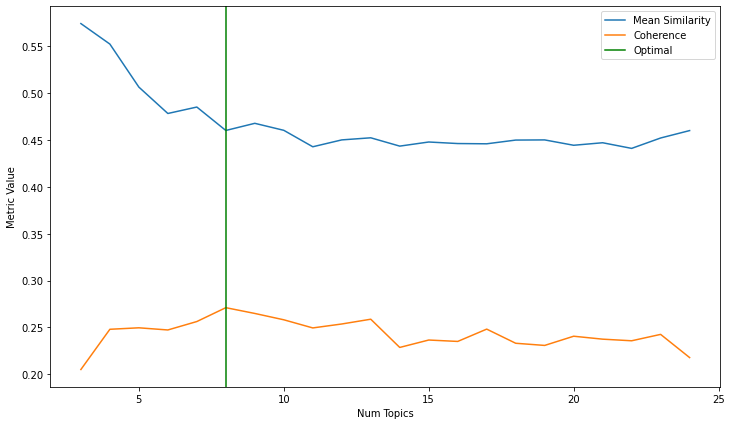

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,7))
ax = plt.axes()
ax.plot(num_topics_list, mean_similarities, label="Mean Similarity")
ax.plot(num_topics_list, coherences, label="Coherence")
plt.axvline(x=optimal_topics_num, color='g', label="Optimal")
plt.legend(fontsize=10)
plt.xlabel("Num Topics")
plt.ylabel("Metric Value")

It appears the number of topics does not drastically affect our data here. 8 seems like a good choice of topic_num but I would consider 13 if I wanted more topics. 8 is fine for now.  
Also our coherence of 0.271 is not good. Let's see if we can improve that after we've taken a look at our model.